In [1]:
import warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace import sarimax

from pmdarima import auto_arima

warnings.filterwarnings("ignore")

### Read the local temperature (local.csv) and energy consumption(power.csv) data as Dataframes

In [2]:
df_t = pd.read_csv('local.csv', index_col=0, parse_dates=True)
df_e = pd.read_csv('power.csv')

### power.csv contains billing month. Create a function to get the end date of previous month. i.e. the month of actual power consumption.

In [3]:
def getbill_endmn(x):
    return datetime.strptime('01-'+x, '%m-%y-%b') - timedelta(days=1)

# reindex 
df_e.index = df_e['Month'].apply(getbill_endmn)

### Local temperature data has a wide range compared to the energy consumption data. We will drop dditional months from temperature data.

In [4]:
# Get min and max date from the energy consumption data and filter temperature data
df_enan = df_e[df_e.isna().any(axis=1)]['kWh']
print(df_e.index.min() , df_e.index.max(), len(df_enan))
df_temp = df_t[df_t.index >= df_e.index.min()][['TMIN', 'TMAX']]

# Seasonal analysis doesn't work with na data, drop the na row from temperature data
# check for Nulls in temperature data, and drop (there are other options)
drpindx = df_temp[df_temp.isna().any(axis=1)].index
df_temp.drop(index=drpindx, inplace=True)

2010-12-31 00:00:00 2021-01-31 00:00:00 13


We expect power consumption to depend on both the minimum (heating) and maximum(cooling) temperatures. We will resample daily maximum, minimum temperature by month.
Apply filter on temperature data to match the energy consumption date range and plot the data. Observe gaps in the energy consumption data, we will fill the gaps later.

Notice the seasonality of temperature(this is expected) and power consumption. We don't see any particular trend. We will check for this later.

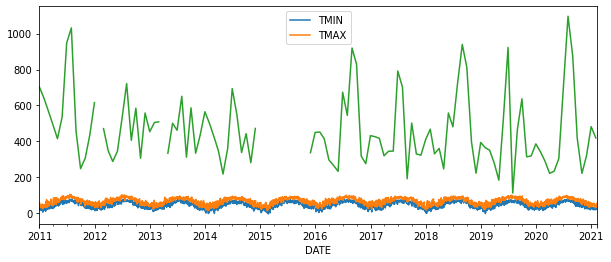

In [5]:
# plot temperature and power consumption
df_temp.plot(figsize=(10, 4))
_ = plt.plot(df_e['kWh'])

### We will calculate the monthly median kWh and fill the kWh nulls with the value for the month.

In [6]:
dct = {i:df_e[df_e.index.month==i].median() for i in range(1,13)}
filldct = {i:dct[i.month] for i in df_enan.index}
df_fill = pd.DataFrame.from_dict(filldct, orient='index', columns=['kWh',])
#df_fill

In [7]:
# Drop the extra month from temperature data, create a dataframe with temperature data and power consumption
mmed = df_temp['TMAX'].resample('M').median()
nmed = df_temp['TMIN'].resample('M').median()
nf_indx = set(mmed.index) - set(df_e.index)
df = pd.DataFrame({'TMax':mmed.tolist(), 'TMin':nmed.tolist()}, index=mmed.index)
df.drop(index=nf_indx, inplace=True)
df = pd.concat((df, df_e['kWh']), axis=1)

# Fill Null kWh with median calcuated above
df.update(df_fill)
# Verify Nulls
print("Total Null count", len(df[df.isna().any(axis=1)]))

Total Null count 0


### Visualize trend and seasonality of power consumption data to match our earlier assumption

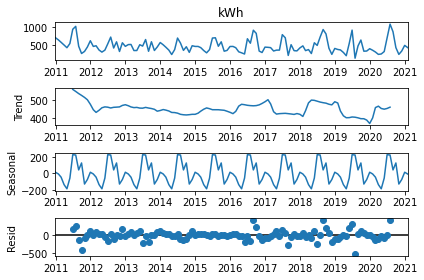

In [8]:
# Specify the (default) model type and period explicitly
ds = df['kWh']
result = seasonal_decompose(ds, model='additive', period=12)
_ = result.plot()

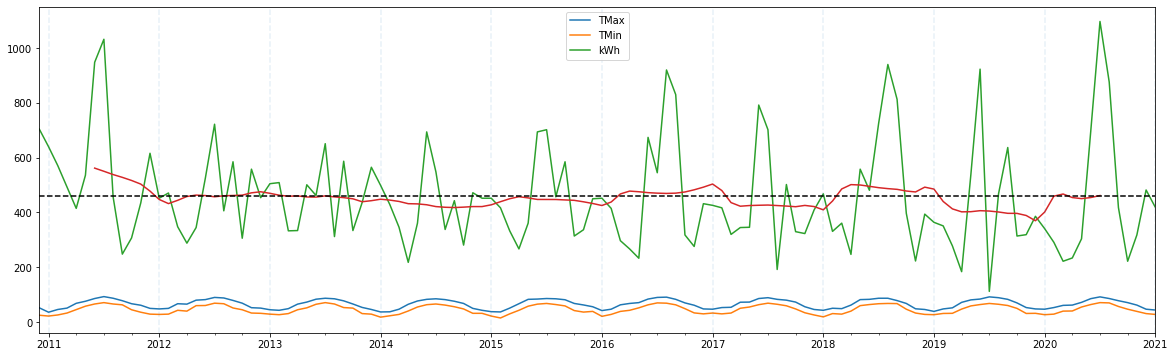

In [9]:
fig = df.plot(figsize=(20, 6))
result.trend.plot()
for yr in ds.index.year.unique():
    fig.axvline(pd.to_datetime(str(yr)+'-01-01'), linestyle='--', alpha=0.1)
_ = fig.axhline(ds.mean(), linestyle='--', color='black')

### Check stationarity of the power consumption time series data using Augmented Dickey-Fuller and KPSS tests

In [10]:
# We don't see a trend, hence chosing 'c', else 'ct'
# null hypothesis - series is non-stationary, has unit-root
t_adf = adfuller(ds, regression='c')
print('ADF Statistic: %f, p-value: %f, Lags: %d, Observations: %d' %t_adf[:4])
print('Critical Values:')
for key, value in t_adf[4].items():
  print('\t%s: %.3f' % (key, value))
if t_adf[1] < 0.05 and t_adf[0] < t_adf[4]["5%"]:
    print("***We reject the null hypothesis. Series is stationary***")
else:
    print("***Series is non-stationary***")

# null hypothesis -> series is level or trend stationary
t_kpss = kpss(ds, regression='c')
print('\nKPSS Statistic: %f, p-value: %f, Lags: %d' %t_kpss[:3])
print('Critical Values:')
for key, value in t_kpss[3].items():
  print('\t%s: %.3f' % (key, value))

if t_kpss[1] < 0.05 and t_kpss[0] > t_kpss[3]["5%"]:
    print("***We reject the null hypothesis. Series is non-stationary***")
else:
    print("***Series is stationary***")

ADF Statistic: -4.168856, p-value: 0.000744, Lags: 11, Observations: 110
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
***We reject the null hypothesis. Series is stationary***

KPSS Statistic: 0.248901, p-value: 0.100000, Lags: 13
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
***Series is stationary***


In [11]:
# We can tranform our data using differencing 
ds_diff = ds.diff()[1:] 
# OR transform using boxcox, observe tranformation indicates almost a log transform(closer to 0)
bc, lmb = boxcox(ds)
print('Lambda: %.6f' % lmb)
#Convert NP array to Series
ds_bc = pd.Series(bc, ds.index)

Lambda: 0.022530


### Exploratory Analysis

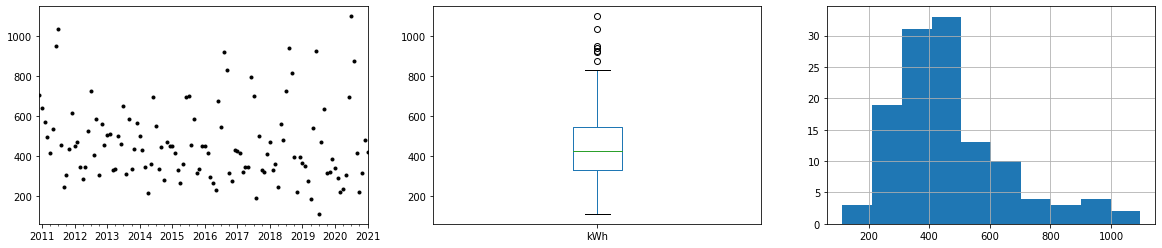

In [12]:
def explore(ds):
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    ds.plot(style='k.', ax=axes[0])
    ds.plot(kind='box', ax=axes[1])
    _ = ds.hist()

explore(ds)

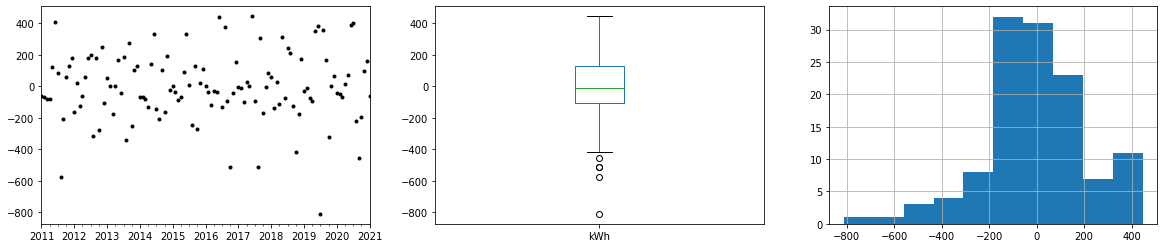

In [13]:
# difference transformed data
explore(ds_diff)

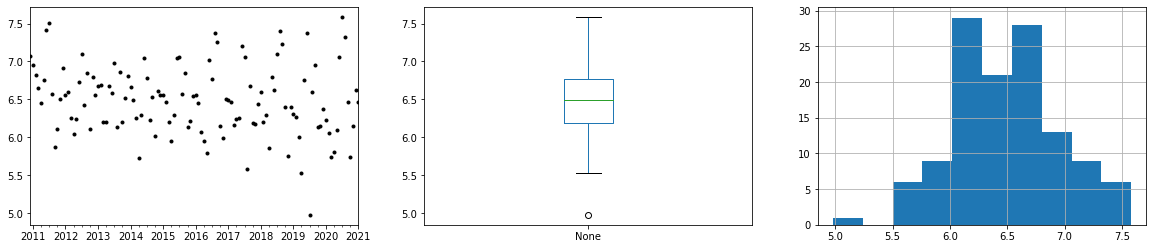

In [14]:
# log transformed data
# Histogram looks closer to a normal distribution when compared to the long tail above
explore(ds_bc)

### We will use log transformed data, ds_bc, to build our model

### Visualize ACF

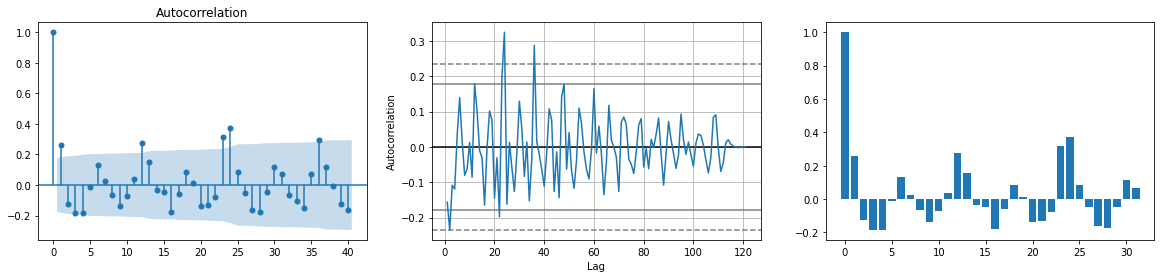

In [15]:
# Different visualizations of ACF
# Observe ACF decaying towards 0 on the subplots
# We see seasonal correlation at 12, 24
v_acf = acf(ds_bc)
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
plot_acf(ds_bc, lags=40, ax=axes[0])
pd.plotting.autocorrelation_plot(ds_diff, ax=axes[1])
_ = plt.bar(range(32), v_acf[:32])

### Visualize PACF

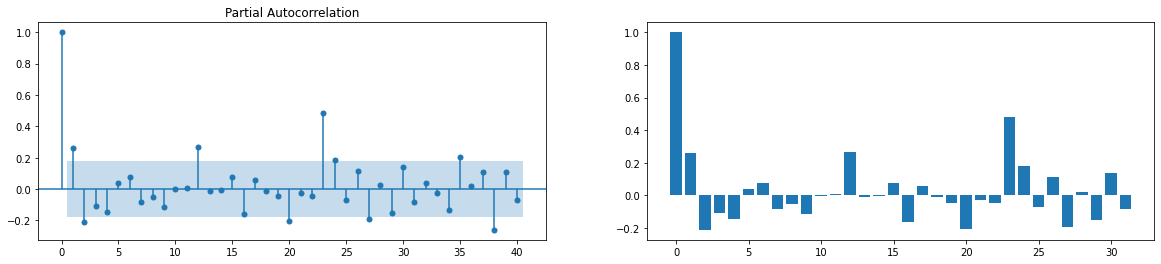

In [16]:
# Visualizations of Partial ACF
# We see seasonal partial correlation at 12, 24
v_pacf = pacf(ds_bc)
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_pacf(ds_bc, lags=40, ax=axes[0])
_ = plt.bar(range(32), v_pacf[:32])

# ARIMA model
### Considering our time series data is stationary, we will be using a ARMA model

In [17]:
# Split data into train, test. Set 1 year data as test data
train = ds_bc[:pd.to_datetime('2020-01-01')]
test = ds_bc[pd.to_datetime('2020-01-01'):]
len(ds_bc), len(train), len(test)

(122, 109, 13)

In [18]:
# Auto-Arima result is not used, see note 2 below for reason. Shown for completeness only
mdl = auto_arima(train, stationary=True)
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -62.829
Date:                Mon, 05 Apr 2021   AIC                            131.658
Time:                        13:49:30   BIC                            139.732
Sample:                             0   HQIC                           134.933
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5004      0.054    121.220      0.000       6.395       6.606
ma.L1          0.2510      0.086      2.931      0.003       0.083       0.419
sigma2         0.1853      0.021      8.713      0.000       0.144       0.227
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 9.47
Prob(Q):                              0.78   Prob(JB):                         0.01
Heteroskedasticity (H):               2.09   Skew:                            -0.44
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Perform manual grid seach to find the best order for AR, MA
# We see no trend in the data, default trend=n
# We can try the following AR values  = 0, 1, 2
# We can try the following MA values  = 0, 1, 2, 3, 4
low = np.inf
for ar in (0, 1, 2):
    for ma in (0, 1, 2, 3, 4):
        mdl =  sarimax.SARIMAX(train, order=(ar, 0, ma), trend='n').fit()
        pred_train = mdl.fittedvalues
        print('AR:%d , MA:%d, AIC:%.6f, BIC:%.6f, RMSE:%.6f, ME:%.6f, MAE:%.6f' \
              %(ar, ma, mdl.aic, mdl.bic, mean_squared_error(train[1:], pred_train[1:]),
                (train[1:] - pred_train[1:]).sum()/len(train[1:]),
                mean_absolute_error(train[1:], pred_train[1:])))
        if mdl.bic < low:
            low = mdl.bic
            aic = mdl.aic
            l_ar, l_ma = ar, ma
print("\nLowest BIC:%.6f, AIC:%.6f, AR:%d MA:%d" %(low, aic, l_ar, l_ma))

AR:0 , MA:0, AIC:719.866050, BIC:722.557398, RMSE:42.368914, ME:6.494263, MAE:6.494263
AR:0 , MA:1, AIC:588.235718, BIC:593.618413, RMSE:12.256191, ME:3.381536, MAE:3.381536
AR:0 , MA:2, AIC:492.136932, BIC:500.210976, RMSE:4.928101, ME:1.923482, MAE:1.954301
AR:0 , MA:3, AIC:435.274580, BIC:446.039971, RMSE:2.846480, ME:1.306129, MAE:1.424070
AR:0 , MA:4, AIC:377.641172, BIC:391.097912, RMSE:1.625710, ME:0.915382, MAE:1.042068
AR:1 , MA:0, AIC:193.059129, BIC:198.441825, RMSE:0.316675, ME:0.016802, MAE:0.413541
AR:1 , MA:1, AIC:147.318280, BIC:155.392324, RMSE:0.201529, ME:-0.082178, MAE:0.352750
AR:1 , MA:2, AIC:144.162699, BIC:154.928091, RMSE:0.192036, ME:-0.075591, MAE:0.344111
AR:1 , MA:3, AIC:144.524872, BIC:157.981611, RMSE:0.188975, ME:-0.079425, MAE:0.342734
AR:1 , MA:4, AIC:145.142154, BIC:161.290242, RMSE:0.186265, ME:-0.082488, MAE:0.335646
AR:2 , MA:0, AIC:184.941027, BIC:193.015071, RMSE:0.288112, ME:0.007446, MAE:0.402147
AR:2 , MA:1, AIC:145.893377, BIC:156.658768, RMS

### Looks like AR:1, MA:2 are good model parameters
#### Note: 
1. If we chose based on visual checks, we probably would be using AR:2 (based on PACF), and MA:1 (based on ACF)
2. If we chose based on auto_arima, our model will consistently underestimate by a large margin

In [20]:
ar = 1
ma = 2                

In [21]:
# define, fit and print model summary
mdl =  sarimax.SARIMAX(train, order=(ar, 0, ma)).fit()
print(mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -68.081
Date:                Mon, 05 Apr 2021   AIC                            144.163
Time:                        13:49:32   BIC                            154.928
Sample:                    12-31-2010   HQIC                           148.528
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.52e-05   6.56e+04      0.000       1.000       1.000
ma.L1         -0.7273      0.091     -7.957      0.000      -0.906      -0.548
ma.L2         -0.2476      0.086     -2.874      0.0

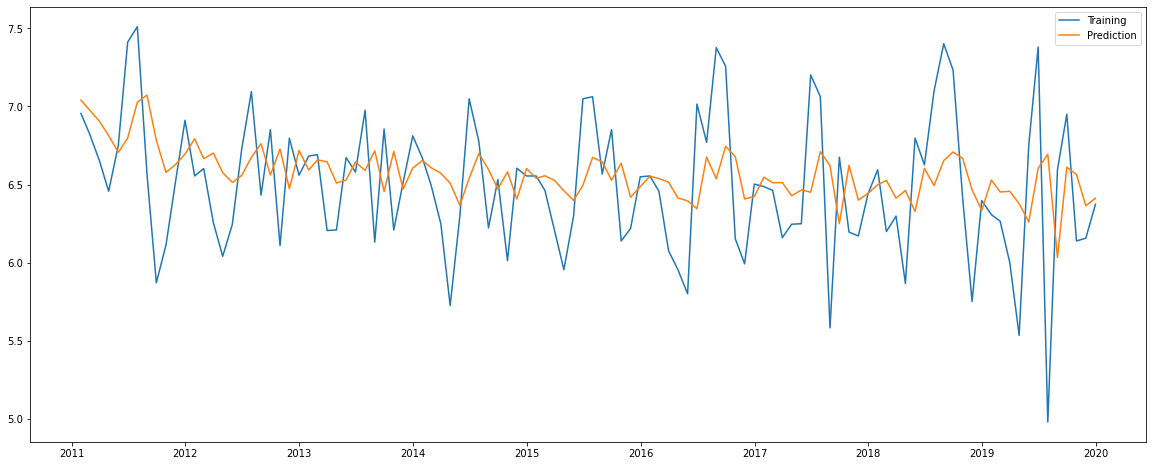

In [22]:
# Visualize fitted values
# First fitted value is 0, ignore
def plt_pred(dct, ysize=8):
    plt.figure(figsize=(20, ysize))
    lgnd = []
    for k, v in dct.items():
        plt.plot(v)
        lgnd.append(k)
    _ = plt.legend(lgnd)

pred_train = mdl.fittedvalues
plt_pred({"Training": train[1:], "Prediction": pred_train[1:]})

### Explore Training residuals

In [23]:
def print_score(dset, pred, rsd, dstype="Training"):
    rmse = mean_squared_error(dset, pred, squared=False)
    mae = mean_absolute_error(dset, pred)
    me = (dset - pred).sum()/len(dset)
    print("%s RMSE: %.6f" % (dstype, rmse))
    print("%s  Mean Absolute Error: %.6f" % (dstype, mae))
    print("%s  Mean Error: %.6f"  % (dstype, me))
    print("\nResiduals Summary:")
    print(rsd.describe())
    return rmse, mae, me 
          
rsd_train = train - pred_train
arma_trn_score = print_score(train[1:], pred_train[1:], rsd_train[1:])

Training RMSE: 0.438219
Training  Mean Absolute Error: 0.344111
Training  Mean Error: -0.075591

Residuals Summary:
count    108.000000
mean      -0.075591
std        0.433663
min       -1.715322
25%       -0.360352
50%       -0.079349
75%        0.199323
max        0.840252
dtype: float64


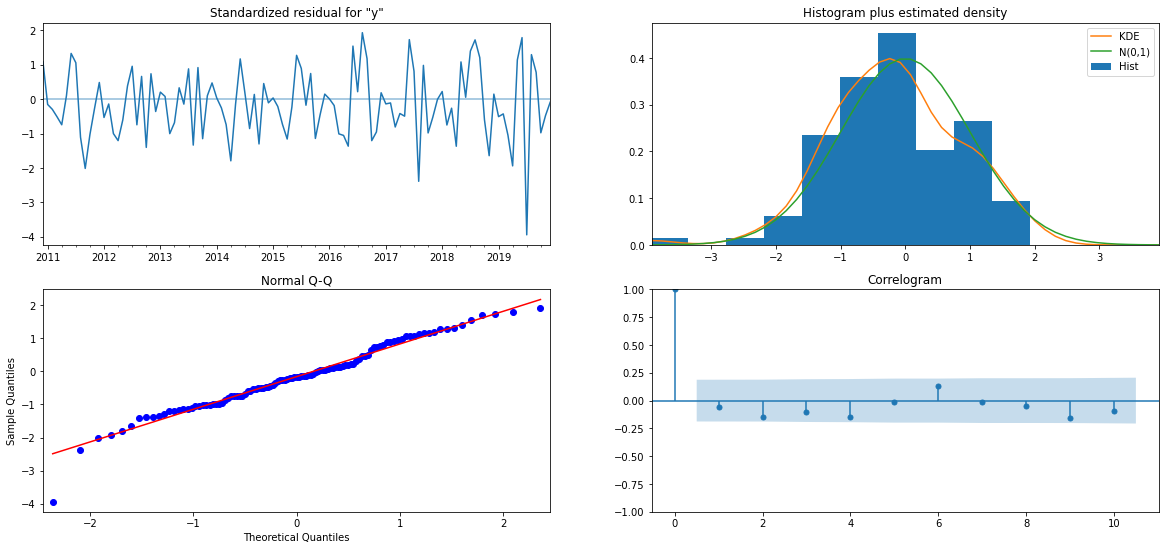

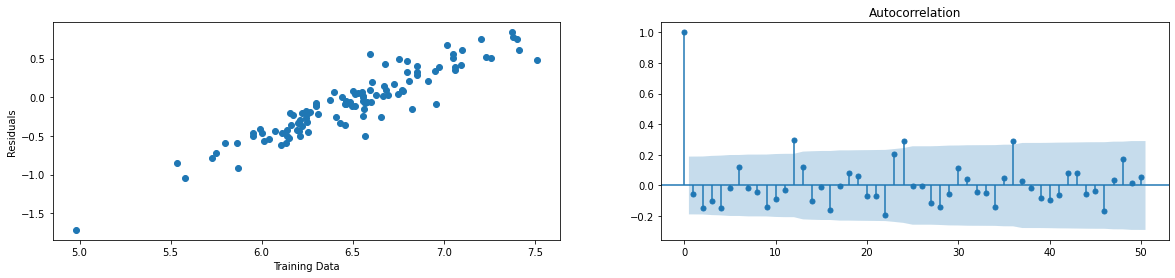

In [24]:
# Residuals resembles a normal distribution
# Model seems to have captured the signal (relationship) with lagged values.
# We don't see much of autocorrelation in residuals, but for seasonality as expected i.e. 12,24,36

# Below custom residual plot is not used
def explore_resid_custom(rsd, data, xlabel, lags=None):
    fig = rsd.plot(figsize=(20, 4))
    fig.axhline(rsd.mean(), linestyle='--', color='black')
    fig, axes = plt.subplots(2, 2, figsize=(20, 9))
    #_  = pd.plotting.autocorrelation_plot(rsd_train[1:], ax=axes[0, 0])
    plot_acf(rsd, lags=lags, ax=axes[0, 0])
    qqplot(rsd, line='r', ax=axes[0, 1])

    rsd.plot(kind='kde', ax=axes[1, 0])
    plt.scatter(x=data, y=rsd)
    plt.xlabel(xlabel)
    _ = plt.ylabel('Residuals')
    
def explore_resid(mdl, rsd, data, xlabel, lags=None):
    mdl.plot_diagnostics(figsize=(20,9))
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    x = axes[0].scatter(x=data, y=rsd)
    x.axes.set_xlabel(xlabel)
    x.axes.set_ylabel('Residuals')
    plot_acf(rsd, lags=lags, ax=axes[1])
    
explore_resid(mdl, rsd_train[1:], train[1:], 'Training Data', 50)

### Let's check how the model performs on Test data

In [25]:
#Perform  rolling forecast 
trn_test_lst = train.tolist()
pred_test = []
for i, v in test.iteritems():
    mdl_t =  sarimax.SARIMAX(trn_test_lst, order=(ar, 0, ma)).fit()
    pred = mdl_t.forecast()[0]
    print( i, "Actual:",ds[i], " Forecast:", inv_boxcox(pred, lmb))
    pred_test.append(pred)
    trn_test_lst.append(v)

2020-01-31 00:00:00 Actual: 341.0  Forecast: 413.7894266659433
2020-02-29 00:00:00 Actual: 291.0  Forecast: 394.41581063867926
2020-03-31 00:00:00 Actual: 222.0  Forecast: 377.74406496023033
2020-04-30 00:00:00 Actual: 234.0  Forecast: 345.58064230867126
2020-05-31 00:00:00 Actual: 304.0  Forecast: 347.62572125531017
2020-06-30 00:00:00 Actual: 697.0  Forecast: 366.73168002040734
2020-07-31 00:00:00 Actual: 1097.0  Forecast: 469.90434253928754
2020-08-31 00:00:00 Actual: 876.0  Forecast: 536.4903439028925
2020-09-30 00:00:00 Actual: 418.0  Forecast: 499.6537421131804
2020-10-31 00:00:00 Actual: 222.0  Forecast: 401.6105617833146
2020-11-30 00:00:00 Actual: 318.0  Forecast: 343.1745024982801
2020-12-31 00:00:00 Actual: 482.0  Forecast: 404.55729042570664
2021-01-31 00:00:00 Actual: 419.0  Forecast: 442.6931096188604


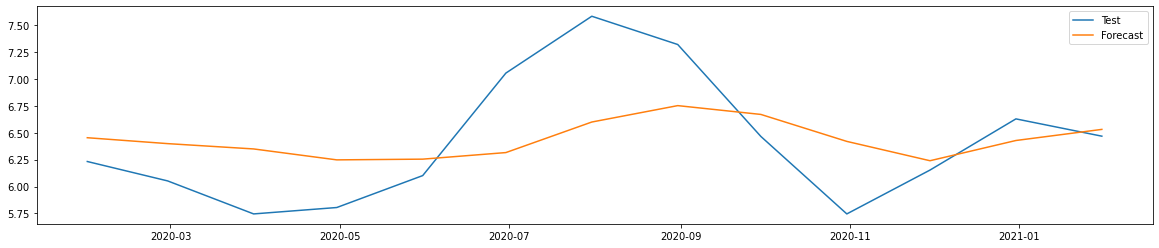

In [26]:
#Forecast on test data
ds_pred_test = pd.Series(pred_test, index=test.index)
plt_pred({"Test":test, 'Forecast':ds_pred_test}, 4)

#### On both training and test data, model is always under predicting the values

### Explore Test Forecast errors

In [27]:
rsd_test = test - ds_pred_test
arma_test_score = print_score(test, ds_pred_test, rsd_test, "Test")

Test RMSE: 0.491214
Test  Mean Absolute Error: 0.406707
Test  Mean Error: -0.023472

Residuals Summary:
count    13.000000
mean     -0.023472
std       0.510688
min      -0.674031
25%      -0.346731
50%      -0.152764
75%       0.200912
max       0.983223
dtype: float64


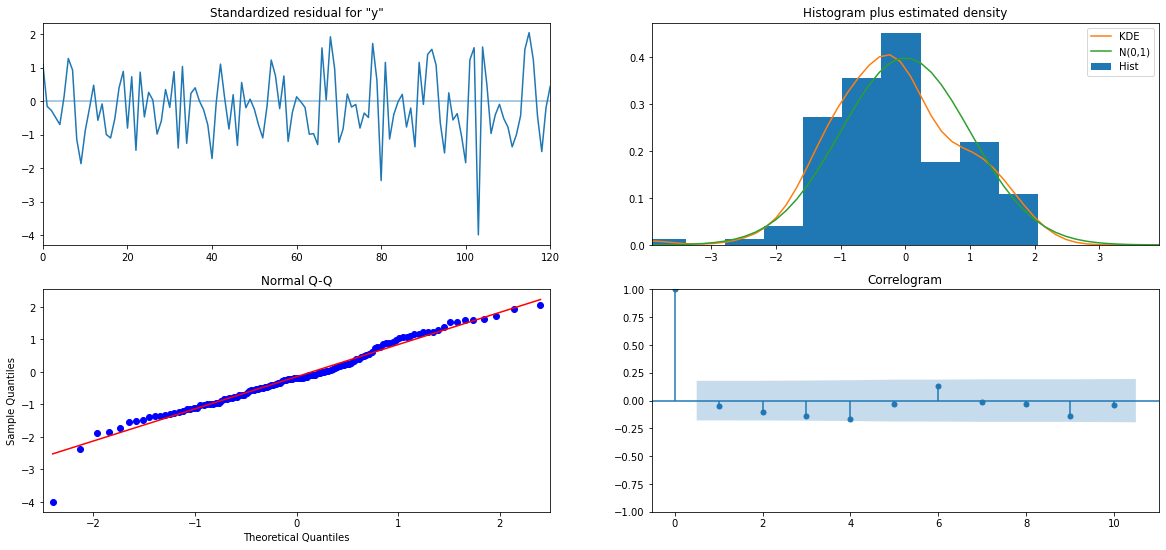

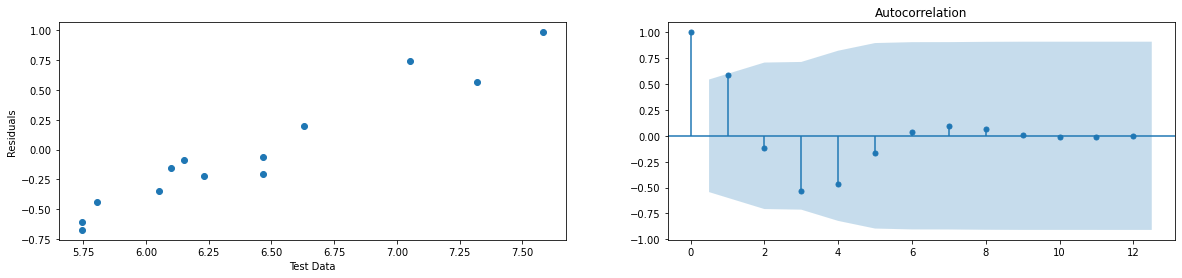

In [28]:
# qqplot and distribution, ACF on test forecast errors
explore_resid(mdl_t, rsd_test, test, 'Test Data')

## Forecast next month's power consumption

In [29]:
mdl =  sarimax.SARIMAX(ds_bc, order=(ar, 0, ma)).fit()

pred = mdl.forecast()
a_f = inv_boxcox(pred[0], lmb)
print("ARMA forecasted power consumption for %s: %.2f" % (pred.index.format("%y-%m")[1], a_f))

ARMA forecasted power consumption for 2021-02-28: 409.66


# SARIMA model

In [30]:
# This step takes time, 1-2 minutes
s_mdl = auto_arima(train, stationary=True, m=12)
s_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -50.931
Date:                              Mon, 05 Apr 2021   AIC                            111.862
Time:                                      13:49:46   BIC                            125.319
Sample:                                           0   HQIC                           117.319
                                              - 109                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3103      0.328      0.946      0.344      -0.333       0.953
ar.L1          0.1183      0.121      0.978      0.328      -0.119       0.355
ar.S.L12       0.9459      0.059     16.125      0.000       0.831       1.061
ma.S.L12      -0.7297      0.144     -5.064      0.000      -1.012      -0.447
sigma2         0.1386      0.011     12.268      0.000       0.116       0.161
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               221.50
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.96
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# This step takes time, 1-2 minutes
# # Perform manual grid seach to find the best order for AR, MA and seasonal AR and MA
# We will try the following AR seasonal values  = 0, 1, 2
# We will try the following MA seasonal values  = 0, 1, 2
# We will try the following AR  values  = 0, 1, 2
# We will try the following MA  values  = 0, 1, 2
low = np.inf
for sar in (0, 1, 2):
    for sma in (0, 1, 2):
        for ar in (0, 1, 2):
            for ma in (0, 1, 2):
                s_mdl =  sarimax.SARIMAX(train, order=(ar, 0, ma),  seasonal_order=(sar, 0, sma, 12) ).fit()
                pred_train = s_mdl.predict()
                print('AR:%d, MA:%d, S_AR:%d, S_MA:%d, AIC:%.6f, BIC:%.6f, RMSE:%.6f, ME:%.6f, MAE:%.6f' \
                      %(ar, ma, sar, sma, s_mdl.aic, s_mdl.bic, mean_squared_error(train[1:], pred_train[1:]),
                        (train[1:] - pred_train[1:]).sum()/len(train[1:]),
                        mean_absolute_error(train[1:], pred_train[1:])))
                if s_mdl.bic < low:
                    low = s_mdl.bic
                    aic = s_mdl.aic
                    l_ar, l_ma, l_sar, l_sma = ar, ma, sar, sma
print("\nLowest BIC:%.6f, AIC:%.6f, AR:%d, MA:%d, S_AR:%d S_MA:%d" %(low, aic, l_ar, l_ma, l_sar, l_sma))

AR:0, MA:0, S_AR:0, S_MA:0, AIC:719.866050, BIC:722.557398, RMSE:42.368914, ME:6.494263, MAE:6.494263
AR:0, MA:1, S_AR:0, S_MA:0, AIC:588.235718, BIC:593.618413, RMSE:12.256191, ME:3.381536, MAE:3.381536
AR:0, MA:2, S_AR:0, S_MA:0, AIC:492.136932, BIC:500.210976, RMSE:4.928101, ME:1.923482, MAE:1.954301
AR:1, MA:0, S_AR:0, S_MA:0, AIC:193.059129, BIC:198.441825, RMSE:0.316675, ME:0.016802, MAE:0.413541
AR:1, MA:1, S_AR:0, S_MA:0, AIC:147.318280, BIC:155.392324, RMSE:0.201529, ME:-0.082178, MAE:0.352750
AR:1, MA:2, S_AR:0, S_MA:0, AIC:144.162699, BIC:154.928091, RMSE:0.192036, ME:-0.075591, MAE:0.344111
AR:2, MA:0, S_AR:0, S_MA:0, AIC:184.941027, BIC:193.015071, RMSE:0.288112, ME:0.007446, MAE:0.402147
AR:2, MA:1, S_AR:0, S_MA:0, AIC:145.893377, BIC:156.658768, RMSE:0.194942, ME:-0.068601, MAE:0.346379
AR:2, MA:2, S_AR:0, S_MA:0, AIC:150.857375, BIC:164.314114, RMSE:0.200546, ME:-0.075097, MAE:0.354309
AR:0, MA:0, S_AR:0, S_MA:1, AIC:610.996518, BIC:616.379214, RMSE:16.147542, ME:3.8502

### Looks like AR:1, MA:1 and Seasonal AR:1, MA:2 are good model parameters
#### Matches auto_arima model recommendation

In [32]:
ar = 1
ma = 1
sar = 1
sma = 2

In [33]:
s_mdl =  sarimax.SARIMAX(train, order=(ar, 0, ma), seasonal_order=(sar, 0, sma, 12)).fit() 
print(s_mdl.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  109
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 -52.991
Date:                                 Mon, 05 Apr 2021   AIC                            117.983
Time:                                         13:50:39   BIC                            134.131
Sample:                                     12-31-2010   HQIC                           124.531
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   8824.205      0.000       1.000       1

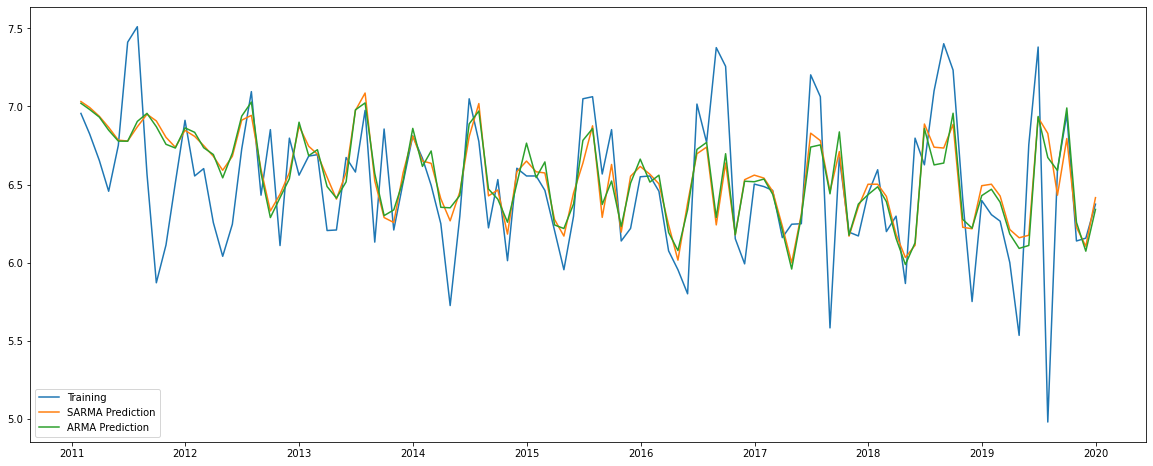

In [34]:
#Visualize fitted values
s_pred_train = s_mdl.fittedvalues
plt_pred({'Training':train[1:], 'SARMA Prediction':s_pred_train[1:], 'ARMA Prediction':pred_train[1:]})

### Explore Training residuals

In [35]:
# Residuals, RMSE, R2 score on training data
s_rsd_train = train - s_pred_train
sarma_trn_score = print_score(train[1:], s_pred_train[1:], s_rsd_train[1:])

Training RMSE: 0.382489
Training  Mean Absolute Error: 0.267872
Training  Mean Error: -0.059770

Residuals Summary:
count    108.000000
mean      -0.059770
std        0.379551
min       -1.848802
25%       -0.212804
50%       -0.062739
75%        0.101492
max        1.135646
dtype: float64


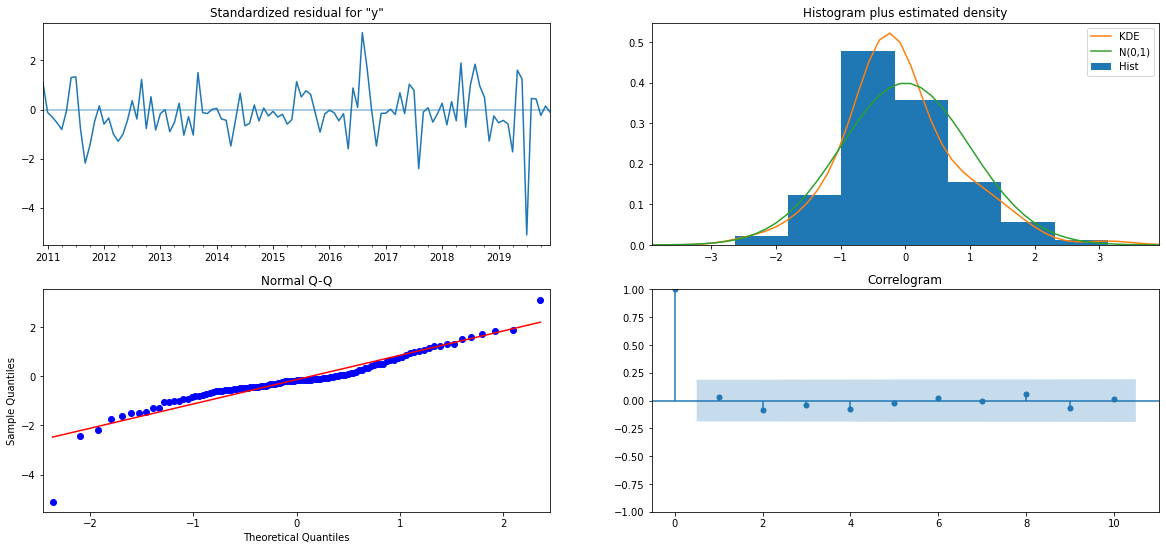

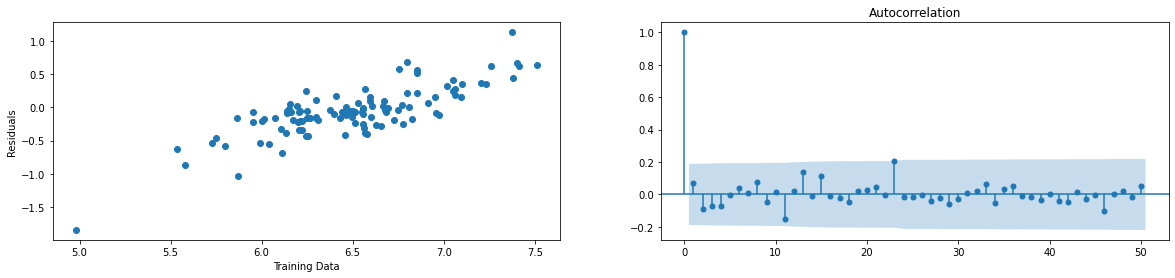

In [36]:
# Residuals resembles a normal distribution and no correlation between lags
explore_resid(s_mdl, s_rsd_train[1:], train[1:], 'Training Data', 50)

In [37]:
#Perform  rolling forecast on Test
trn_test_lst = train.tolist()
s_pred_test = []
for i, v in test.iteritems():
    s_mdl_t =  sarimax.SARIMAX(trn_test_lst, order=(ar, 0, ma), seasonal_order=(sar ,0, sma, 12)).fit()
    pred = s_mdl_t.forecast()[0]
    print( i, "Actual:",ds[i], " Forecast:", inv_boxcox(pred, lmb))
    s_pred_test.append(pred)
    trn_test_lst.append(v)

2020-01-31 00:00:00 Actual: 341.0  Forecast: 418.78222540606964
2020-02-29 00:00:00 Actual: 291.0  Forecast: 358.34760293115556
2020-03-31 00:00:00 Actual: 222.0  Forecast: 333.66889187805396
2020-04-30 00:00:00 Actual: 234.0  Forecast: 282.2630328650679
2020-05-31 00:00:00 Actual: 304.0  Forecast: 393.07144997043866
2020-06-30 00:00:00 Actual: 697.0  Forecast: 532.2642563978654
2020-07-31 00:00:00 Actual: 1097.0  Forecast: 472.9425155747032
2020-08-31 00:00:00 Actual: 876.0  Forecast: 395.99386736193156
2020-09-30 00:00:00 Actual: 418.0  Forecast: 621.2598802645145
2020-10-31 00:00:00 Actual: 222.0  Forecast: 306.6920813340112
2020-11-30 00:00:00 Actual: 318.0  Forecast: 250.89968762539655
2020-12-31 00:00:00 Actual: 482.0  Forecast: 382.8452125912894
2021-01-31 00:00:00 Actual: 419.0  Forecast: 416.5955132055694


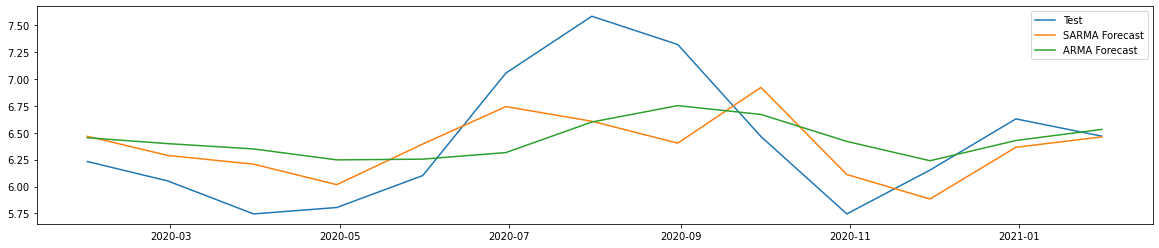

In [38]:
#Visualize forecast on test data
s_ds_pred_test = pd.Series(s_pred_test, index=test.index)
plt_pred({'Test':test, 'SARMA Forecast':s_ds_pred_test, 'ARMA Forecast':ds_pred_test}, 4)

### Explore Test Forecast errors

In [39]:
s_rsd_test = test - s_ds_pred_test
sarma_test_score = print_score(test, s_ds_pred_test, s_rsd_test, 'Test')

Test RMSE: 0.466589
Test  Mean Absolute Error: 0.385085
Test  Mean Error: 0.037039

Residuals Summary:
count    13.000000
mean      0.037039
std       0.484108
min      -0.462335
25%      -0.293137
50%      -0.212491
75%       0.269133
max       0.975820
dtype: float64


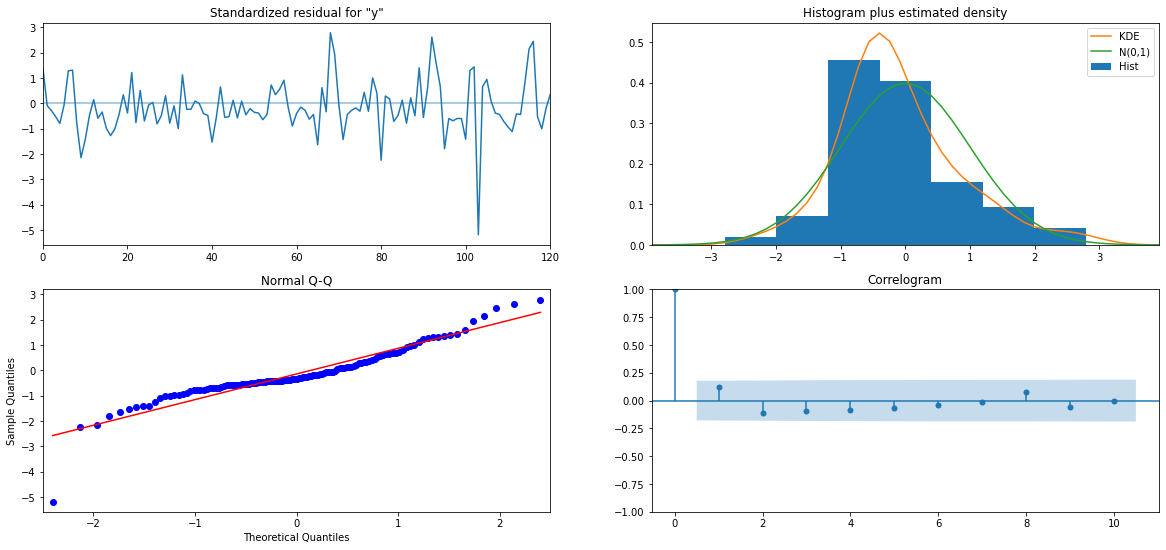

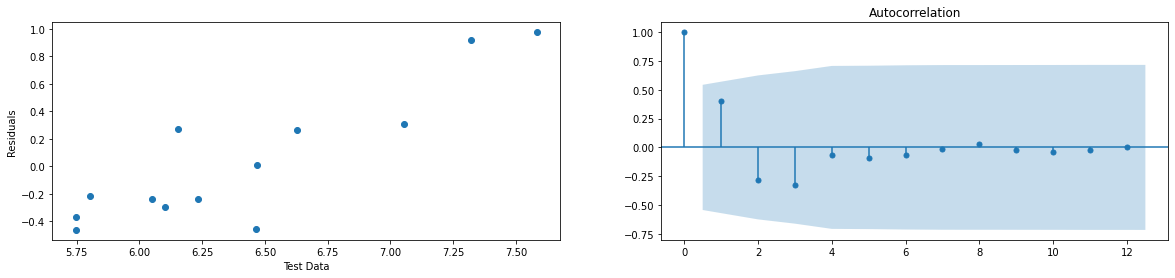

In [40]:
# qqplot and distribution, ACF on test forecast errors
explore_resid(s_mdl_t, s_rsd_test, test, 'Test Data')

In [41]:
# Highlighting a few default parameters below
s_mdl = sarimax.SARIMAX(ds_bc, order=(ar, 0, ma),
                        seasonal_order=(sar, 0, sma, 12),
                        trend='n', 
                        enforce_stationarity=True,
                        enforce_invertibility=True).fit()
pred = s_mdl.forecast()
s_f = inv_boxcox(pred[0], lmb)
print("SARMA Forecasted power consumption for %s: %.2f" % (pred.index.format("%y-%m")[1], s_f))

SARMA Forecasted power consumption for 2021-02-28: 346.48


## SARIMA with exogenous regressor
#### We will use average monthly temperature as exog

In [42]:
df['TAvg'] = (df['TMax'] + df['TMin'])/2
ds_avg_train = df['TAvg'][:pd.to_datetime('2020-01-01')]

# This step takes time, 1-2 minutes
s_mdl_x = auto_arima(train, exog=ds_avg_train, stationary=True, m=12)
s_mdl_x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -50.931
Date:                              Mon, 05 Apr 2021   AIC                            111.862
Time:                                      13:51:08   BIC                            125.319
Sample:                                           0   HQIC                           117.319
                                              - 109                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3103      0.328      0.946      0.344      -0.333       0.953
ar.L1          0.1183      0.121      0.978      0.328      -0.119       0.355
ar.S.L12       0.9459      0.059     16.125      0.000       0.831       1.061
ma.S.L12      -0.7297      0.144     -5.064      0.000      -1.012      -0.447
sigma2         0.1386      0.011     12.268      0.000       0.116       0.161
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               221.50
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.96
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
ar = 1
ma = 0
sar = 1
sma = 1

In [44]:
s_mdl_x =  sarimax.SARIMAX(train, exog=ds_avg_train,
                           order=(ar, 0, ma), seasonal_order=(sar, 0, sma, 12)).fit()
print(s_mdl_x.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -83.825
Date:                              Mon, 05 Apr 2021   AIC                            177.650
Time:                                      13:51:08   BIC                            191.107
Sample:                                  12-31-2010   HQIC                           183.107
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TAvg           0.0059      0.011      0.556      0.578      -0.015       0.027
ar.L1          0.97

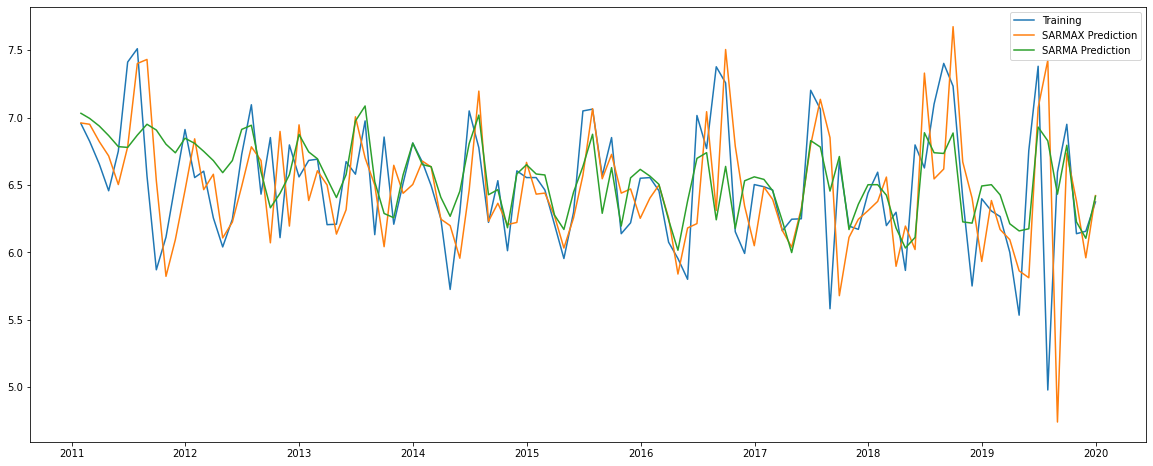

In [45]:
#Visualize fitted values
s_pred_train_x = s_mdl_x.fittedvalues
plt_pred({'Training':train[1:], 'SARMAX Prediction':s_pred_train_x[1:], 'SARMA Prediction':s_pred_train[1:]})

In [46]:
# Residuals, RMSE, R2 score on training data
s_rsd_train_x = train - s_pred_train_x
sarmax_trn_score = print_score(train[1:], s_pred_train_x[1:], s_rsd_train_x[1:])

Training RMSE: 0.504248
Training  Mean Absolute Error: 0.349656
Training  Mean Error: 0.028218

Residuals Summary:
count    108.000000
mean       0.028218
std        0.505805
min       -2.447684
25%       -0.253225
50%        0.011895
75%        0.297175
max        1.853965
dtype: float64


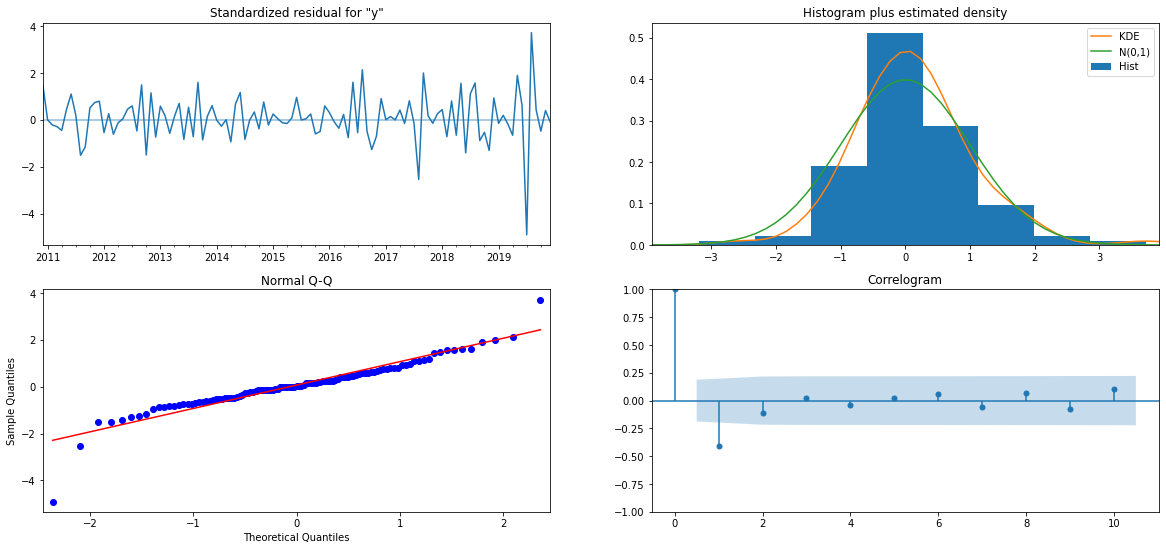

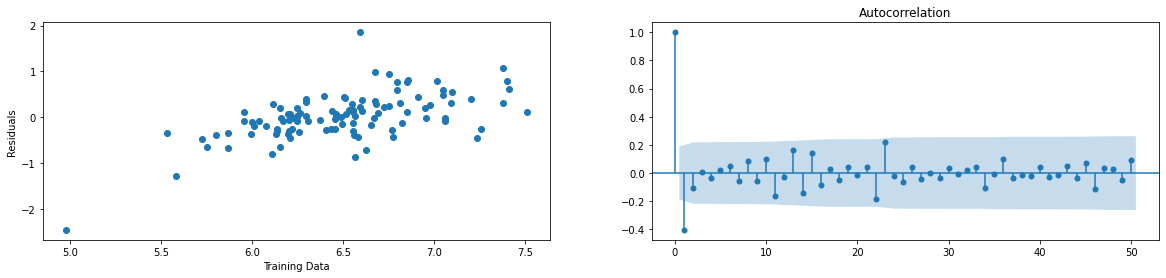

In [47]:
# Residuals resembles a normal distribution and no correlation between lags
explore_resid(s_mdl_x, s_rsd_train_x[1:], train[1:], 'Training Data', 50)

In [48]:
#Perform  rolling forecast on Test
trn_test_lst = train.tolist()
exog_lst = ds_avg_train.to_list()
s_pred_test_x = []
for i, v in test.iteritems():
    s_mdl_t_x =  sarimax.SARIMAX(trn_test_lst, exog=exog_lst, 
                               order=(ar, 0, ma), seasonal_order=(sar ,0, sma, 12)).fit()
    pred = s_mdl_t_x.forecast(exog=df['TAvg'][i])[0]
    print( i, "Actual:",ds[i], " Forecast:", inv_boxcox(pred, lmb))
    s_pred_test_x.append(pred)
    trn_test_lst.append(v)
    exog_lst.append(df['TAvg'][i])

2020-01-31 00:00:00 Actual: 341.0  Forecast: 373.5135741239631
2020-02-29 00:00:00 Actual: 291.0  Forecast: 305.4302104264117
2020-03-31 00:00:00 Actual: 222.0  Forecast: 256.504703362846
2020-04-30 00:00:00 Actual: 234.0  Forecast: 170.42497954696907
2020-05-31 00:00:00 Actual: 304.0  Forecast: 354.4086564829005
2020-06-30 00:00:00 Actual: 697.0  Forecast: 433.4622694606956
2020-07-31 00:00:00 Actual: 1097.0  Forecast: 450.4342795039015
2020-08-31 00:00:00 Actual: 876.0  Forecast: 1039.4159004713308
2020-09-30 00:00:00 Actual: 418.0  Forecast: 979.2428118037923
2020-10-31 00:00:00 Actual: 222.0  Forecast: 262.92537276488105
2020-11-30 00:00:00 Actual: 318.0  Forecast: 228.072886617999
2020-12-31 00:00:00 Actual: 482.0  Forecast: 360.39874023575965
2021-01-31 00:00:00 Actual: 419.0  Forecast: 459.2437205817296


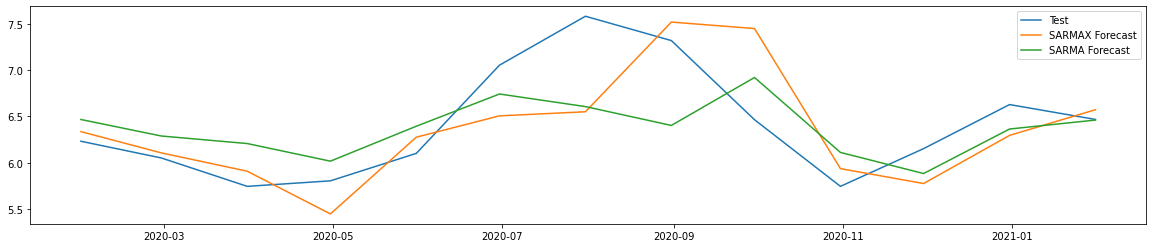

In [49]:
#Visualize forecast errors on test data
s_ds_pred_test_x = pd.Series(s_pred_test_x, index=test.index)
plt_pred({'Test':test, 'SARMAX Forecast':s_ds_pred_test_x, 'SARMA Forecast':s_ds_pred_test}, 4)

### Explore Test Forecast errors

In [50]:
s_rsd_test_x = test - s_ds_pred_test_x
sarmax_test_score = print_score(test, s_ds_pred_test_x, s_rsd_test_x, 'Test')

Test RMSE: 0.470145
Test  Mean Absolute Error: 0.355762
Test  Mean Error: 0.051417

Residuals Summary:
count    13.000000
mean      0.051417
std       0.486407
min      -0.984713
25%      -0.174816
50%      -0.103967
75%       0.357211
max       1.031809
dtype: float64


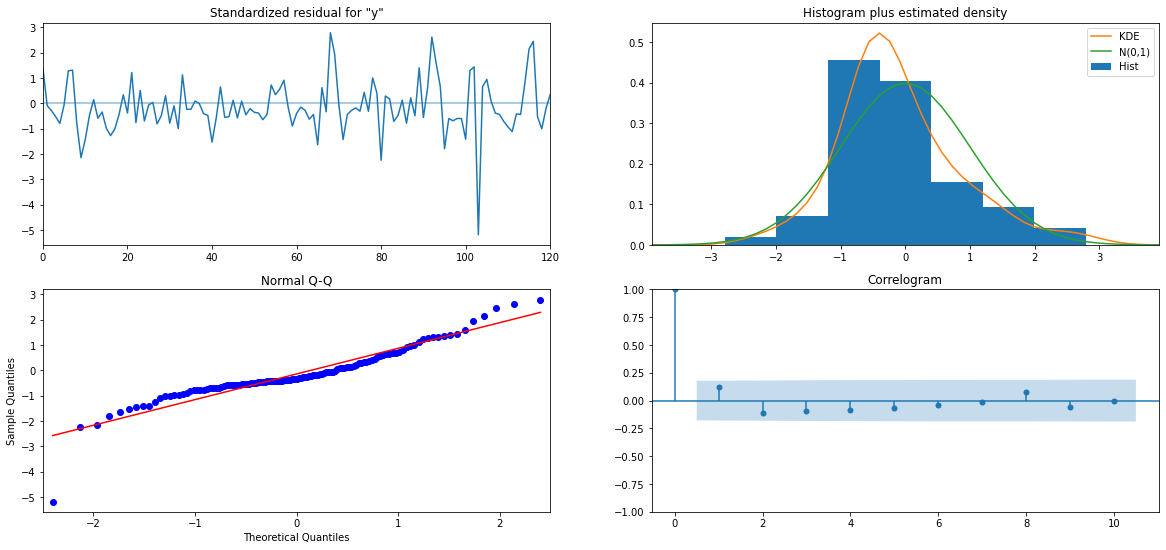

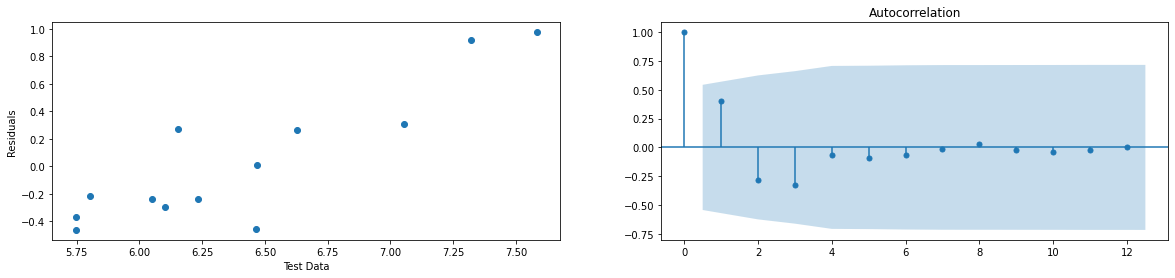

In [51]:
# qqplot and distribution, ACF on test forecast errors
explore_resid(s_mdl_t, s_rsd_test, test, 'Test Data')

In [52]:
s_mdl_x =  sarimax.SARIMAX(ds_bc, exog=df['TAvg'], order=(ar, 0, ma),
                        seasonal_order=(sar, 0, sma, 12)).fit()

In [53]:
exog_avg_m = df[df.index.month==2]['TAvg'].mean()
#exog_max_m = df[df.index.month==2]['TMax'].mean()
#exog_min_m= df[df.index.month==2]['TMin'].mean()
pred = s_mdl_x.forecast(exog=exog_avg_m)
s_f_x = inv_boxcox(pred[0], lmb)
print("SARMAX Forecasted power consumption for %s: %.2f" % (pred.index.format("%y-%m")[1], s_f_x))

SARMAX Forecasted power consumption for 2021-02-28: 371.42


With Maximum, Minimum monthly temperature as exog, forecast values are 371.30 and 371.75 respectively

### Actual power consumption for 2021-02: 362kWh

In [54]:
display(pd.DataFrame({"Type": ("Train RMSE", "Train MAE", "Train ME", "Test RMSE", "Test  MAE", "Test  ME", "Next Forecast"),
                   "ARMA": (arma_trn_score + arma_test_score + (a_f,)),
                   "SARMA": (sarma_trn_score + sarma_test_score + (s_f,)),
                   "SARMAX": (sarmax_trn_score + sarmax_test_score + (s_f_x,))
                  })
       )


,Type,ARMA,SARMA,SARMAX
0,Train RMSE,0.438219,0.382489,0.504248
1,Train MAE,0.344111,0.267872,0.349656
2,Train ME,-0.075591,-0.059770,0.028218
3,Test RMSE,0.491214,0.466589,0.470145
4,Test MAE,0.406707,0.385085,0.355762
5,Test ME,-0.023472,0.037039,0.051417
6,Next Forecast,409.656275,346.480196,371.419689


## Conclusion:
Due to the seasonal nature of data, as expected SARIMA provides a better forecast than ARIMA. 
Even though, the forecast for the next month is close to the actual value, when test predictions are considered forecasting is off by a good margin especially on highs and lows. We probably need a better modeling tool than ARIMA, SARIMA or SARIMAX.